# Классификация методом k ближайших соседей (kNN)

## Описание набора данных

Набор данных описывает характеристики звезд - кандидатов в пульсары. Информация собрана во время исследования High Time Resolution Universe Survey (South). 

Информация об атрибутах:

Каждый кандидат описывается 8 непрерывными переменными и одной переменной класса. Первые четыре представляют собой простые статистические данные, полученные из интегрированного профиля пульса (свернутого профиля). Это массив непрерывных переменных, которые описывают версию сигнала с разрешением по долготе, который был усреднен как по времени, так и по частоте. Остальные четыре переменные аналогичным образом получаются из кривой DM-SNR. Описание признаков кратко изложено ниже:

1. Среднее значение интегрального профиля.
2. Стандартное отклонение интегрированного профиля.
3. Избыточный эксцесс интегрального профиля.
4. Асимметрия интегрированного профиля.
5. Среднее значение кривой DM-SNR.
6. Стандартное отклонение кривой DM-SNR.
7. Избыточный эксцесс кривой DM-SNR.
8. Асимметрия кривой DM-SNR.
9. Класс

## Загрузка и подготовка данных

In [103]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [104]:
data = pd.read_csv('pulsar_stars_new.csv')
data.index += 1
data.head()

,MIP,STDIP,EKIP,SIP,MC,STDC,EKC,SC,TG
1,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
2,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
3,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
4,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
5,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Разделяем датафрейм на предикторы и отклики и для предикторов строим "ящики с усами", чтобы оценить порядок значений каждого из предикторов, а также установить, надо ли проводить нормировку данных. 

In [105]:
X = data.drop(['TG'], axis=1)
y = data['TG']

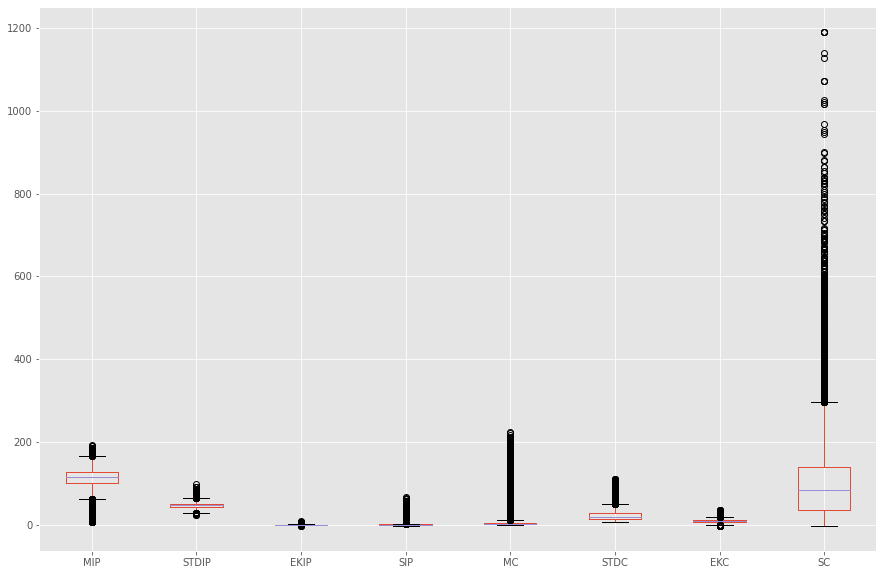

In [106]:
X.boxplot(figsize=(15,10))

Проведем линейную нормировку данных. Это необходимо сделать, так как значения предикторов имеют разный порядок.

In [107]:
X_normed = (X - X.min()) / (X.max() - X.min())
X_normed.head()

,MIP,STDIP,EKIP,SIP,MC,STDC,EKC,SC
1,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890
2,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443
3,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610
4,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581
5,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369


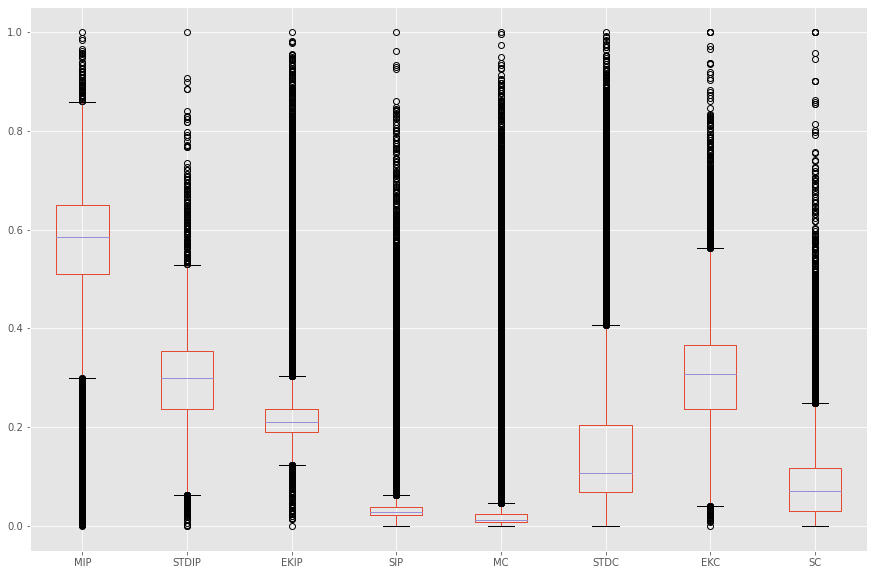

In [108]:
X_normed.boxplot(figsize=(15,10))

Видно, что теперь все предикторы принимают значения только от 0 до 1. 

Разделим выборку на тренировочную и тестовую, используя встроенную функцию train_test_split.

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normed, y, test_size=0.2, random_state=42)

## Постановка задачи и построение модели

Наша задача - обучить классификатор, который на основе восьми известных ему характеристик звезды должен определить, является ли эта звезда пульсаром. 

Для проведения классификации будем использовать метод kNN (k-nearest neighbors). 

Попытаемся определить оптимальное число ближайших соседей (k). Для всех k в диапазоне от 1 до 50 вычислим среднюю частоту ошибок, а также precision, recall и F-меру.

Так как F-мера является средним гармоническим precision и recall, то для вычисления оптимального значения k оставим только ее и среднюю частоту ошибок, а графики зависимости от k precision и recall изобразим только для наглядности.

In [110]:
from sklearn import metrics

error_rates_array = []
precision_array = []
recall_array = []
F_array = []

for i in np.arange(1, 50):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates_array.append(np.mean(new_predictions != y_test))
    prec_i = metrics.precision_score(y_test, new_predictions)
    precision_array.append(prec_i)
    rec_i = metrics.recall_score(y_test, new_predictions)
    recall_array.append(rec_i)
    F_array.append((2 * prec_i * rec_i) / (prec_i + rec_i))

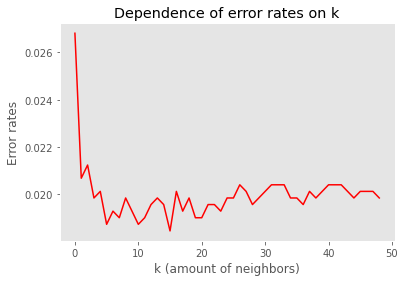

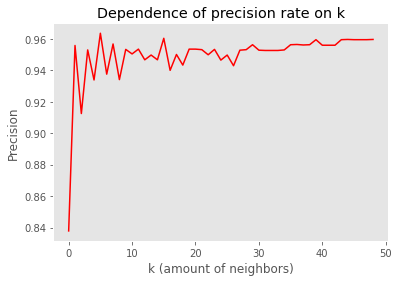

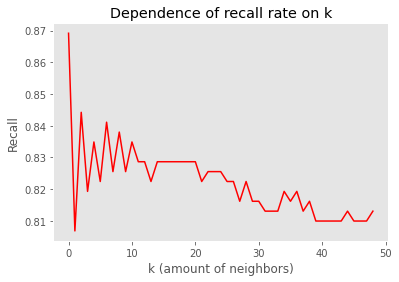

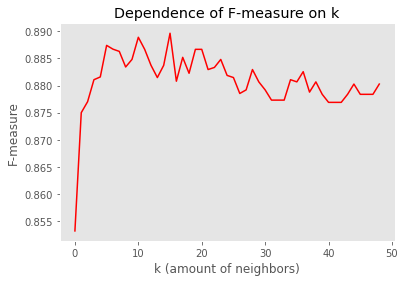

Если оценивать по доле неверных предсказаний, оптимальное количество ближайших соседей равно 16
Доля неверных предсказаний для k = 16 равна 0.01844
Если оценивать по F-мере, оптимальное количество ближайших соседей равно 16
F-мера для k = 16 равна 0.88963


In [111]:
graph_titles = ['Dependence of error rates on k', 'Dependence of precision rate on k', 'Dependence of recall rate on k', 'Dependence of F-measure on k']
y_titles = ['Error rates', 'Precision', 'Recall', 'F-measure']
graph_arrays = [error_rates_array, precision_array, recall_array, F_array]

for i in range(4):
    plt.figure()
    plt.xlabel('k (amount of neighbors)')
    plt.ylabel(y_titles[i])
    plt.title(graph_titles[i])
    plt.grid()
    plt.plot(graph_arrays[i], c='red')
    plt.show()

er_num = list(enumerate(graph_arrays[0], 0))
k_optimal = min(er_num, key=lambda i : i[1])
print('Если оценивать по доле неверных предсказаний, оптимальное количество ближайших соседей равно', k_optimal[0] + 1)
print('Доля неверных предсказаний для k = 16 равна', round(graph_arrays[0][15], 5))

er_num = list(enumerate(graph_arrays[3], 0))
k_optimal = max(er_num, key=lambda i : i[1])
print('Если оценивать по F-мере, оптимальное количество ближайших соседей равно', k_optimal[0] + 1)
print('F-мера для k = 16 равна', round(graph_arrays[3][15], 5))

**Оптимальное количество ближайших соседей для данной задачи определяется однозначно и равно 16.**

## Оценка модели

Далее построим ROC-кривую - соотношение между долей истинно положительных и ложно положительных объектов и найдем AUC. 

Модель тем точнее, чем ближе AUC к 1. Значение AUC, равное 0.5, соответствует случайному гаданию.


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


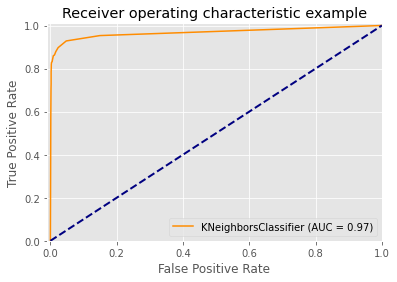

In [112]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

model = KNeighborsClassifier(n_neighbors=16)

model.fit(X_train, y_train)
probs_1 = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, probs_1)


metrics.plot_roc_curve(model, X_test, y_test, color='darkorange') 
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

Построим далее матрицу ошибок. 

Confusion matrix, without normalization
[[3248   11]
 [  55  266]]
Normalized confusion matrix
[[1.   0.  ]
 [0.17 0.83]]


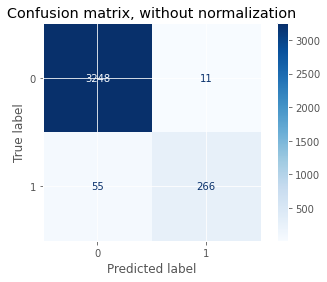

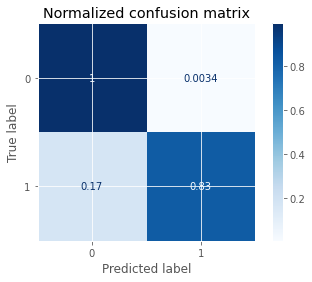

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay

optimal_model = KNeighborsClassifier(n_neighbors=16)
classifier = optimal_model.fit(X_train, y_train)
y_pred = optimal_model.predict(X_train)

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=['0', '1'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Заключение

Был построен классификатор, производящий бинарную классификацию по восьми числовым признакам. Было установленоо оптимальное количество ближайших соседей, равное 16. 
При k = 16 значение AUC для классификатора равно 0.97, F-мера примерно равна 0.89.